### Example workflow of machine learning algorithm performace evaluation in python sci-kit learn (classification)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

# classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression

The dataset is from UCI [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00357/). Here is the attribute information:

* date time year-month-day hour:minute:second 
* Temperature, in Celsius 
* Relative Humidity, % 
* Light, in Lux 
* CO2, in ppm 
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air 
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

In [2]:
occupancy_data = pd.read_table("datatraining.txt", delimiter=",")
occupancy_data.head(3)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1


#### Data preparation: split to training set and validation set

In [3]:
X, y = occupancy_data.iloc[:, 1:-1].values, occupancy_data.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2)

In [4]:
print("Total size: ", X.shape)
print("Training size: ", X_train.shape)
print("Validation size: ", X_val.shape)
print("Ratio of training set: {:.4f}".format(X_train.shape[0] / X.shape[0]))

Total size:  (8143, 5)
Training size:  (6514, 5)
Validation size:  (1629, 5)
Ratio of training set: 0.8000


In [5]:
# check class distribution: we can see this is not a well balanced data
occupancy_data.Occupancy.value_counts() / occupancy_data.shape[0]

0    0.78767
1    0.21233
Name: Occupancy, dtype: float64

In [6]:
# check missing observations under each variable
occupancy_data.isnull().sum(axis=0)

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

#### Training classifier: logistic regression

In [7]:
lr_clf1 = LogisticRegression()
lr_clf1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# get coefficients of regression function
lr_clf1.coef_

array([[ -4.93656025e-01,   3.88980715e-02,   1.89370490e-02,
          4.25209936e-03,  -3.52149908e-05]])

#### Evaluation: validation set performance

In [9]:
y_val_pred = lr_clf1.predict(X_val)
print("Confusion matrix: \n", confusion_matrix(y_val, y_val_pred), "\n")
print("Accuracy: \n", accuracy_score(y_val, y_val_pred))

Confusion matrix: 
 [[1260    9]
 [   0  360]] 

Accuracy: 
 0.994475138122


#### Evaluation: k-folds cross-validation

In [10]:
# check parameters of logistic regression
lr_clf1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [11]:
lr_clf_tuned = LogisticRegression()
cv_params = {
    "C": [.5, .75, 1, 1.5],
    "class_weight": [{0: .5, 1: .5}, {0: .3, 1: .7}],
    "fit_intercept": [True, False],
    "penalty": ["l1", "l2"]
}
lr_clf_cv = GridSearchCV(lr_clf_tuned, cv_params, cv=5)
lr_clf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7}], 'penalty': ['l1', 'l2'], 'C': [0.5, 0.75, 1, 1.5], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# get cv error
lr_clf_cv.best_score_

0.98679766656432299

In [13]:
# get best hyper-parameters
lr_clf_cv.best_params_

{'C': 0.5,
 'class_weight': {0: 0.5, 1: 0.5},
 'fit_intercept': True,
 'penalty': 'l1'}

#### Evaluation: ROC and precision recall curve

In [14]:
# get assignment probability
y_val_score = lr_clf1.predict_proba(X_val)

# FPR and TPR
fpr, tpr, thresholds = roc_curve(y_val, y_val_score[:, 1])

# calculate AUC
auc_score = auc(fpr, tpr)

# precision and recall
precision, recall, _ = precision_recall_curve(y_val, y_val_score[:, 1])

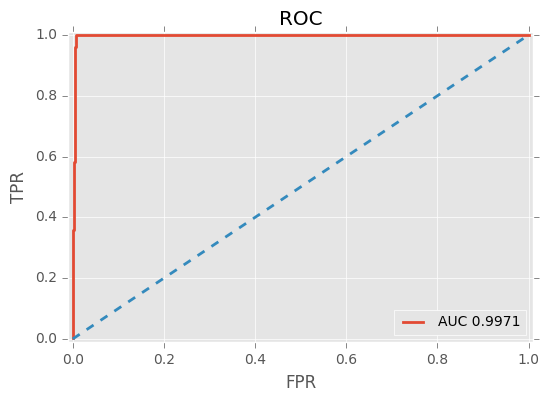

In [15]:
# ROC
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([-.01, 1.01])
plt.ylim([-.01, 1.01])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend(["AUC {:.4f}".format(auc_score)], fontsize=10, loc=0)
plt.show()

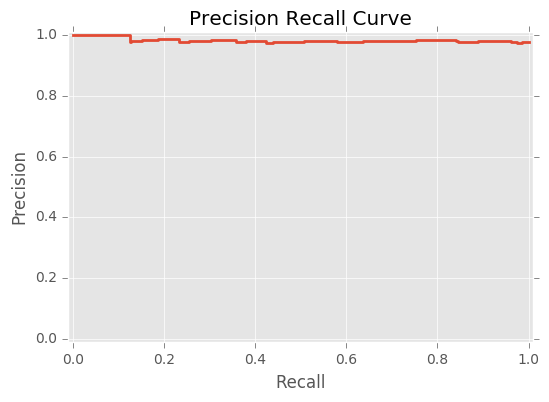

In [16]:
# precision recall curve
plt.step(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([-.01, 1.01])
plt.ylim([-.01, 1.01])
plt.title("Precision Recall Curve")
plt.show()